In [1]:
from surge_multiplier_mdp import mdp_value_iteration as mdp
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
plt.style.use('seaborn-poster')

In [2]:
multipliers = np.arange(1, 8, 0.1)
alphas = np.arange(0, 10, 0.1)

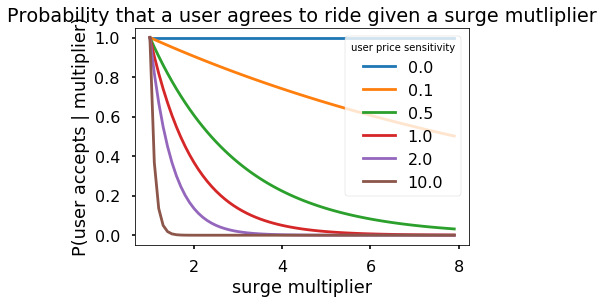

In [3]:
# User acceptance given a multiplier
for a in [0, 0.1, 0.5, 1, 2, 10]:
    p = mdp.acceptance_probability(a, multipliers)
    plt.plot(multipliers, p, label="%0.1f"%a)
plt.legend(loc='upper right', title="user price sensitivity")
plt.ylabel("P(user accepts | multiplier)")
plt.xlabel("surge multiplier")
plt.title("Probability that a user agrees to ride given a surge mutliplier")
None

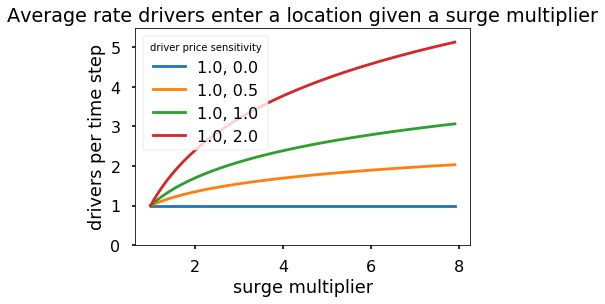

In [4]:
# Driver attraction given a multiplier
for b0, b1 in itertools.product([1.0], [0, 0.5, 1.0, 2.0]):
    n_drivers = mdp.vehicle_in_rate(b0, b1, multipliers)
    plt.plot(multipliers, n_drivers, label="%0.1f, %0.1f" % (b0, b1))
plt.legend(loc='upper left', title="driver price sensitivity")
plt.ylabel("drivers per time step")
plt.xlabel("surge multiplier")
plt.title("Average rate drivers enter a location given a surge multiplier")
plt.ylim([0, 5.5])
None

In [5]:
def errorbar(ax, x, y, yerr, **kw):
    h, = ax.plot(x, y, **kw)
    ax.fill_between(x, y-yerr, y+yerr, alpha=0.5, edgecolor='none', **kw)
    return h

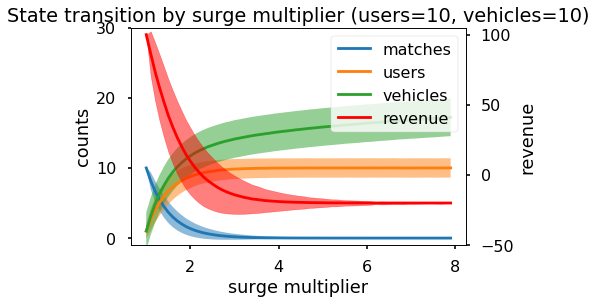

In [6]:
p = mdp.Parameters(
    alpha=2.0,
    beta0=1.0,
    beta1=3.0,
    p_stay=0.9,
    demand_rate=1.0,
    base_cost=10.0,
    empty_cost=2.0,
    discount=0.98,
)
state = mdp.State(
    users=10,
    vehicles=10,
)
def plot_transition(p, state):
    matches = np.zeros_like(multipliers)
    matches_err = np.zeros_like(multipliers)
    users = np.zeros_like(multipliers)
    users_err = np.zeros_like(multipliers)
    vehicles = np.zeros_like(multipliers)
    vehicles_err = np.zeros_like(multipliers)
    revenue = np.zeros_like(multipliers)
    revenue_err = np.zeros_like(multipliers)
    for i, m in enumerate(multipliers):
        matched, users_next, vehicles_next = mdp.transition(p, state, m, 100000)
        r = mdp.reward(p, state, matched, m)
        revenue[i]     = r.mean()
        revenue_err[i] = r.std()
        matches[i]     = matched.mean()
        matches_err[i] = matched.std()
        users[i]       = users_next.mean()
        users_err[i]   = users_next.std()
        vehicles[i]    = vehicles_next.mean()
        vehicles_err   = vehicles_next.std()
    f, ax_count = plt.subplots()
    ax_rev = ax_count.twinx()
    h1 = errorbar(ax_count, multipliers, matches, yerr=matches_err, label="matches")
    h2 = errorbar(ax_count, multipliers, users, yerr=users_err, label="users")
    h3 = errorbar(ax_count, multipliers, vehicles, yerr=vehicles_err, label="vehicles")
    h4 = errorbar(ax_rev, multipliers, revenue, yerr=revenue_err, label="revenue", color='red')
    plt.legend(handles=[h1, h2, h3, h4])
    plt.xlabel("surge multiplier")
    ax_count.set(ylabel="counts", xlabel="surge multiplier", ylim=[-1, 30])
    ax_rev.set(ylabel="revenue", ylim=[-50, 105])
    plt.title("State transition by surge multiplier (users=%d, vehicles=%d)" % state)

plot_transition(p, state)

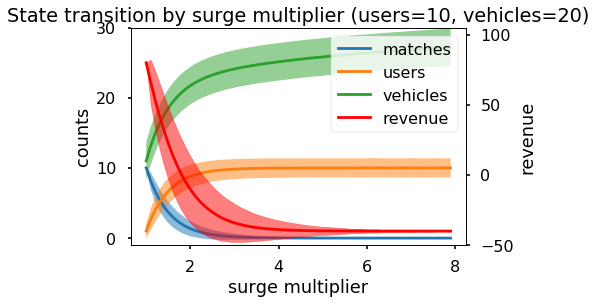

In [7]:
state = mdp.State(
    users=10,
    vehicles=20,
)
plot_transition(p, state)

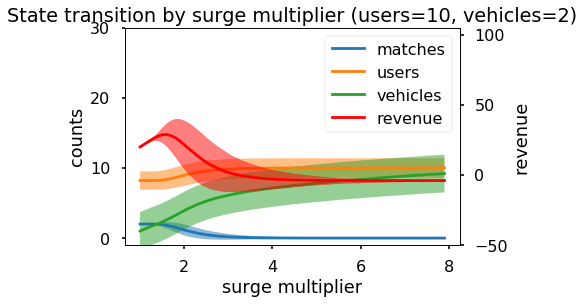

In [8]:
state = mdp.State(
    users=10,
    vehicles=2,
)
plot_transition(p, state)

In [10]:
reload(mdp)

<module 'surge_multiplier_mdp.mdp_value_iteration' from 'surge_multiplier_mdp/mdp_value_iteration.py'>

In [12]:
tol = 0.5
n_samples = 1000
users_max = 10
vehicles_max = 15
v0 = np.ones([vehicles_max, users_max])
policy, values, policies, convergence = mdp.value_iteration(tol, v0, multipliers, p, n_samples)

iteration: 0
convergence distance: 1498.4348
iteration: 1
convergence distance: 91.2498
iteration: 2
convergence distance: 83.6053
iteration: 3
convergence distance: 88.6523
iteration: 4
convergence distance: 94.0143
iteration: 5
convergence distance: 97.2779
iteration: 6
convergence distance: 97.8632
iteration: 7
convergence distance: 96.3476
iteration: 8
convergence distance: 94.9795
iteration: 9
convergence distance: 93.3330
iteration: 10
convergence distance: 91.1866
iteration: 11
convergence distance: 89.2941
iteration: 12
convergence distance: 87.4241
iteration: 13
convergence distance: 85.1110
iteration: 14
convergence distance: 82.8321
iteration: 15
convergence distance: 80.5557
iteration: 16
convergence distance: 78.5669
iteration: 17
convergence distance: 76.0561
iteration: 18
convergence distance: 74.9720
iteration: 19
convergence distance: 75.0954
iteration: 20
convergence distance: 73.9907
iteration: 21
convergence distance: 73.0773
iteration: 22
convergence distance: 72.6